In [55]:
#Data based on
from bs4 import BeautifulSoup # For HTML parsing
import urllib # Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline
import requests
from collections import defaultdict

In [278]:
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''

#     try:
    site = urllib.request.urlopen(website).read() # Connect to the job posting
#     except: 
#         print('hi')
#         return   # Need this in case the website isn't there anymore or some other weird connection problem 
    
    soup_obj = BeautifulSoup(site) # Get the html from the site
    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    
    

    text = soup_obj.get_text() # Get the text from this
    
    
    lines = (line.strip() for line in text.splitlines()) # break into lines

        
        
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each

    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  
        
    
    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk) # Get rid of all blank lines and ends of line
   
        
    # Now clean out all of the unicode junk (this line works great!!!)
        
#     try:
#     text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
#     except:                                                            # in a way that this works, can occasionally throw
#         return                                                         # an exception
      
        
    text = re.sub("[^a-zA-Z+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
#                                              Also include + for C++
    text_str = text.lower()
    text = text.lower().split()  # Go to lower case and split them apart
        

    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w for w in text if not w in stop_words]
    
    two_plus_words = []
    two_plus_word_list = ['sql server', 'deep learning']
    
    for x in two_plus_word_list:
        if re.findall(x,text_str):
            two_plus_words.append(x)
        
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
#                             # or not on the website)
    text.extend(two_plus_words)

    return text_str, text



In [275]:
sample = text_cleaner('https://www.indeed.com/jobs?q=deep%20learning&l=San%20Diego%2C%20CA&vjk=138493d97c64466f')
sample[:20]

['deep learning']


/Users/stevehuang/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/stevehuang/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


('deep learning jobs  employment in san diego  ca   indeed com skip to job postings  searchclose find jobscompany reviewsfind salariesfind resumesemployers   post job upload your resume sign in   what where advanced job search job title  keywords or company city  state  or zip deep learning jobs in san diego  ca filter results by  sort by  relevance   date distance  exact location only within   miles within    miles within    miles within    miles within    miles within     miles salary estimate                                                           3       3   job type full time       internship      part time     contract     commission     temporary  3  location san diego  ca       la jolla  ca     poway  ca     chula vista  ca  3  encinitas  ca     la mesa  ca     rancho bernardo  ca     el cajon  ca     san ysidro  ca     rancho santa fe  ca     deep learning jobs nationwide more   company best buy      qualcomm      teradata     cymer     accesso     samsung semiconductor  inc

In [284]:
def skills_info(city = None, state = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
        
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
    
    final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://www.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
#         final_site_list = ['http://www.indeed.com/jobs?q="', final_job, '"']
        print("please enter a city")
        return

    final_site = ''.join(final_site_list) # Merge the html address together into one string

    base_url = 'http://www.indeed.com'
        
    try:
        html = urllib.request.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html) # Get the html from the first page
#     print(soup)
    # Now find out how many jobs there were
    
    num_jobs_area = soup.find(id = 'searchCount').get_text() # Now extract the total number of jobs found
#     num_jobs_area = [element.text for element in soup.find_all('searchCount')]
                                                                    # The 'searchCount' object has this

    job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    
    job_numbers = job_numbers[1]
    total_num_jobs = job_numbers
#     print(job_numbers)
#     if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
#         total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
#     else:
#         total_num_jobs = int(job_numbers[2]) 
    
    city_title = city
#     if city is None:
#         city_title = 'Nationwide'
        
    print('There were', total_num_jobs, 'jobs found in ', city_title) # Display how many jobs were found
    
    num_pages = int(total_num_jobs)/10 # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    num_pages = int(num_pages)
    
    job_descriptions = [] # Store all our descriptions in this list
    job_str = ""
    all_titles = []
    for i in range(0,num_pages+1): # Loop through all of our search result pages
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        print(current_page)
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
            
        html_page = urllib.request.urlopen(current_page).read() # Get the page
#         print(html_page)    
#         break
        page_obj = BeautifulSoup(html_page) # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
        job_URLS = [base_url + link.get('href') for link in job_link_area.find_all('a') if link.get('href') is not None] # Get the URLS for the jobs
        job_titles = [link.get('title') for link in job_link_area.find_all('a') if link.get('data-tn-element') == 'jobTitle']
        all_titles += job_titles

        job_URLS = list(filter(lambda x: 'clk' in x, job_URLS)) # Now get just the job related URLS    
        for j in range(0,len(job_URLS)):
            final_str, final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                job_descriptions.append(final_description)
                job_str += final_str
# #             sleep(1) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 

# #         final_description = text_cleaner(job_URLS[0])
# #     final_str, final_description = text_cleaner('https://www.indeed.com/viewjob?jk=621649a8e8de05e5&tk=1c8duj379bqhr8st&from=serp&vjs=3')
# #     if final_description: # So that we only append when the website was accessed correctly
# #             job_descriptions.append(final_description)

    title_dict = Counter(all_titles)
    print('Done with collecting the job postings!')    
    print('There were', len(job_descriptions), 'jobs successfully found.')

    
    doc_frequency = Counter() # This will create a full counter of our terms. 
    [doc_frequency.update(item) for item in job_descriptions] # List comp
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    regtext = re.findall("\w*sql\w*",job_str)
    regtext = list(set(regtext))
    regtext.remove('sql')
    
    y = dict()
    for x in regtext:
        y[x.capitalize()] = doc_frequency[x]
    
    others = Counter(y)
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala'], 'Julia': doc_frequency['julia']})
 
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    method_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout'],
                'TensorFlow':doc_frequency['tensorflow'], 'Deep Learning':doc_frequency['deep learning']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb'],'MySQL':doc_frequency['MySQL'],
                    'SQL Server':doc_frequency['sql server']})
                         
    overall_total_skills = prog_lang_dict + analysis_tool_dict + method_dict + database_dict + others # Combine our Counter objects

    final_frame = pd.DataFrame.from_dict(overall_total_skills, orient='index').reset_index() # Convert these terms to a dataframe
    title_frame = pd.DataFrame.from_dict(title_dict, orient='index').reset_index()

    final_frame = final_frame.rename(columns={'index':'Term', 0:'NumPostings'})
    title_frame = title_frame.rename(columns={'index':'Title', 0:'Occurence'})

    #     # Change the values to reflect a percentage of the postings 
    
    final_frame['NumPostingsPercent'] = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 
    
    # Sort the data for plotting purposes
    
    final_frame.sort_values(by =['NumPostings'], ascending = False, inplace = True)
    
    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', y = 'NumPostingsPercent', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
#     print(final_frame)    
    return final_frame, title_frame # End of the function


/Users/stevehuang/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/stevehuang/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


There were 39 jobs found in  San Diego
http://www.indeed.com/jobs?q=%22data+scientist%22&l=San+Diego%2C+CA&start=0
http://www.indeed.com/jobs?q=%22data+scientist%22&l=San+Diego%2C+CA&start=10
http://www.indeed.com/jobs?q=%22data+scientist%22&l=San+Diego%2C+CA&start=20
http://www.indeed.com/jobs?q=%22data+scientist%22&l=San+Diego%2C+CA&start=30
Done with collecting the job postings!
There were 37 jobs successfully found.
             Term  NumPostings  NumPostingsPercent
1          Python           26           70.270270
0               R           18           48.648649
19            SQL           17           45.945946
2            Java           15           40.540541
3             C++           12           32.432432
18  Deep Learning           12           32.432432
14          Spark           11           29.729730
9             SAS           10           27.027027
12         Hadoop           10           27.027027
4          Matlab            9           24.324324
16           Hi

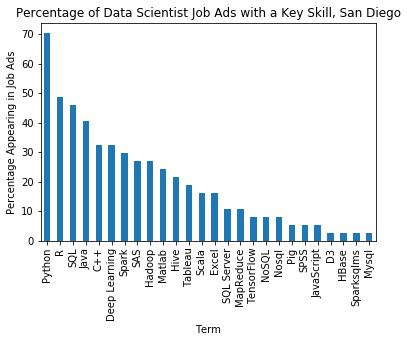

In [285]:
job, title = skills_info(city = 'San Diego', state = 'CA') 
print(job)
print(title)

